In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error

import fbprophet 

import glob
import sklearn
import torch
%matplotlib inline

## Extract the training data and validation data from row data (daily infection number as well as cumulative)

In [6]:
real_world_data_path = r'../../Week 5/RKI_COVID19.csv'
rki_covid_data = pd.read_csv(real_world_data_path)
rki_covid_data.head(3)

rki_covid_data["Date"] = pd.to_datetime(rki_covid_data['Refdatum'], format='%Y/%m/%d %H:%M:%S.%f')
rki_covid_data["Date"] = rki_covid_data['Date'].dt.date
rki_covid_data.head(3)

infected_per_day = rki_covid_data[rki_covid_data['NeuerFall'].isin([0,1])].groupby("Date", as_index=True).AnzahlFall.sum()
infected_per_day.head(3)

# select training data from 01.03 to 20.04
training_data_daily = infected_per_day[datetime.date(2020,3,1):datetime.date(2020,4,20)]
training_data_daily.head(3)

# cumulative number
training_data_cum = training_data_daily.cumsum().values
training_data_cum

# select validate data from 21.04 to 30.04
valid_data_daily = infected_per_day[datetime.date(2020,4,21):datetime.date(2020,4,30)]
valid_data_daily.head(3) 

# cumulative number
valid_data_cum = valid_data_daily.cumsum().values + training_data_cum[len(training_data_cum)-1]
valid_data_cum

array([152200, 153957, 155584, 157050, 158212, 158978, 160163, 161252,
       162342, 163499])

In [17]:
def three_labels_df(train, forcast, valid, title):
    plt.plot(train, color="blue", label="training data") 
    plt.plot(forcast, color="green",  label="prediction data")
    plt.plot(valid, color="yellow",  label="validation data") 
    plt.legend(loc='upper left')
    plt.title(title)

def three_labels_list(train, forcast, valid, title):
    predict_len = len(forcast)
    restart_day = len(train) - 1
    plt.plot(train, color="blue", label="training data") 
    plt.plot(range(restart_day, restart_day + predict_len), forcast, color="green",  label="prediction data")
    plt.plot(range(restart_day, restart_day + predict_len), valid, color="yellow",  label="validation data")
    plt.legend(loc='upper left') 
    plt.title(title)

## AutoReg

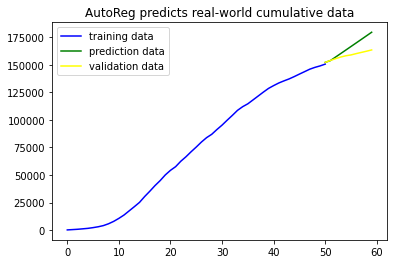

In [18]:
# AR example
from statsmodels.tsa.ar_model import AutoReg
from random import random

# fit model
model = AutoReg(training_data_cum, lags=1)
model_fit = model.fit()

# make prediction
predict_len = len(valid_data_cum)
restart_day = len(training_data_cum) - 1
yhat = model_fit.predict(restart_day, restart_day + predict_len - 1)

three_labels_list(training_data_cum, yhat, valid_data_cum, "AutoReg predicts real-world cumulative data")

In [19]:
autoreg_cum_sq_error = sqrt(mean_squared_error(yhat, valid_data_cum))
print('mean square error: ' + str(autoreg_cum_sq_error))

mean square error: 8857.908396614099


In [20]:
# AR example
from statsmodels.tsa.ar_model import AutoReg
from random import random

# fit model
model = AutoReg(training_data_daily, lags=1)
model_fit = model.fit()

# make prediction
train_len = len(training_data_daily)
valid_len = len(valid_data_daily)
yhat = model_fit.predict(train_len, train_len + valid_len - 1)
print(yhat)

2020-04-21   NaN
2020-04-22   NaN
2020-04-23   NaN
2020-04-24   NaN
2020-04-25   NaN
2020-04-26   NaN
2020-04-27   NaN
2020-04-28   NaN
2020-04-29   NaN
2020-04-30   NaN
Freq: D, dtype: float64


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


## ARMA 

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[111971.2059114   73067.06005925  73067.06005925  73067.06005925
  73067.06005925  73067.06005925  73067.06005925  73067.06005925
  73067.06005925  73067.06005925]


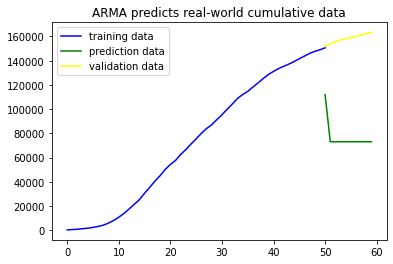

In [21]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(training_data_cum, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
train_len = len(training_data_cum)
valid_len = len(valid_data_cum)
yhat = model_fit.predict(train_len, train_len + valid_len - 1)
print(yhat)

three_labels_list(training_data_cum, yhat, valid_data_cum, "ARMA predicts real-world cumulative data")

In [22]:
arma_cum_sq_error = sqrt(mean_squared_error(yhat, valid_data_cum))
print('mean square error: ' + str(arma_cum_sq_error))

mean square error: 82561.67711724302


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


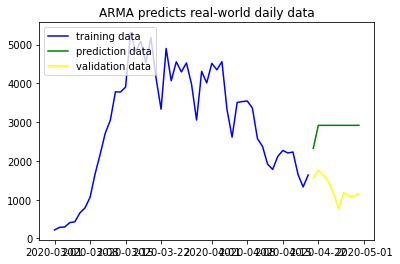

In [23]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(training_data_daily, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
train_len = len(training_data_daily)
valid_len = len(valid_data_daily)
yhat = model_fit.predict(train_len, train_len + valid_len - 1)
#print(yhat)

three_labels_df(training_data_daily, yhat, valid_data_daily, "ARMA predicts real-world daily data")

In [24]:
arma_daily_sq_error = sqrt(mean_squared_error(yhat, valid_data_daily))
print('mean square error: ' + str(arma_daily_sq_error))

mean square error: 1617.010328277575


## ExponentialSmoothing 

D:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
D:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


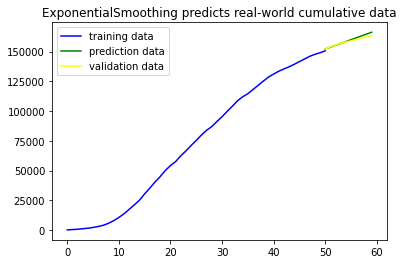

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# 
model = ExponentialSmoothing(training_data_cum, trend='add', damped=False, seasonal=None, seasonal_periods=0)
model_fit = model.fit()
# make prediction
train_len = len(training_data_cum)
valid_len = len(valid_data_cum)
yhat = model_fit.predict(train_len, train_len + valid_len - 1)
#print(yhat)

three_labels_list(training_data_cum, yhat, valid_data_cum, "ExponentialSmoothing predicts real-world cumulative data")


In [53]:
ex_cum_sq_error = sqrt(mean_squared_error(yhat, valid_data_cum))
print('mean square error: ' + str(ex_cum_sq_error))

mean square error: 1406.1209551110762


## FBprophet 

In [25]:
# fit the column names to waht fbprophet demanded
fb_train_daily = pd.DataFrame()
fb_train_daily['ds'] = training_data_daily.index 
fb_train_daily['y'] = training_data_daily.values
fb_train_daily.head(3) 

fb_valid_daily = pd.DataFrame()
fb_valid_daily['ds'] = valid_data_daily.index 
fb_valid_daily['y'] = valid_data_daily.values
fb_valid_daily.head(3) 

fb_train_cum = pd.DataFrame()
fb_train_cum['ds'] = training_data_daily.index 
fb_train_cum['y'] = training_data_cum
fb_train_cum.head(3) 

fb_valid_cum = pd.DataFrame()
fb_valid_cum['ds'] = valid_data_daily.index 
fb_valid_cum['y'] = valid_data_cum
fb_valid_cum.head(3) 

,ds,y
0,2020-04-21,152200
1,2020-04-22,153957
2,2020-04-23,155584


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
D:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


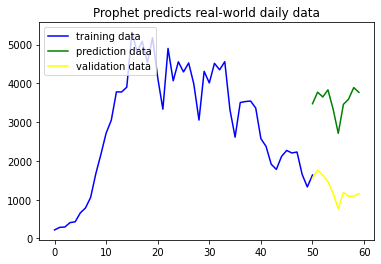

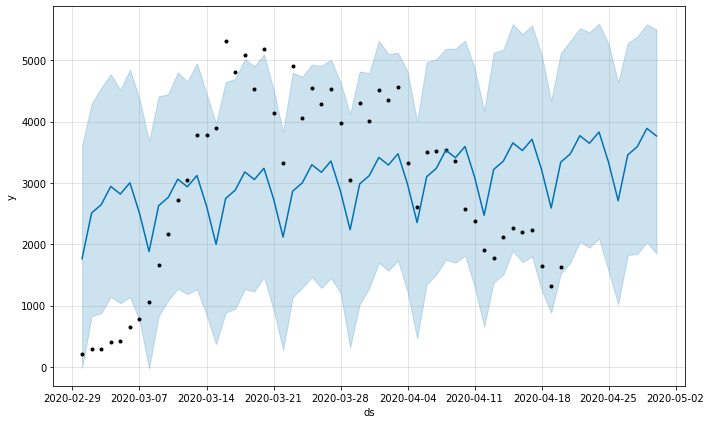

In [26]:
pro = fbprophet.Prophet()
pro.fit(fb_train_daily)
pro_periods = len(valid_data_daily)
future = pro.make_future_dataframe(periods=pro_periods, freq='D')
forecast = pro.predict(future)
three_labels_list(training_data_daily.values, forecast['yhat'][len(training_data_daily):], valid_data_daily.values, "Prophet predicts real-world daily data")
fig = pro.plot(forecast)
#a = add_changepoints_to_plot(fig.gca(), pro, forecast)

In [27]:
fb_daily_sq_error = sqrt(mean_squared_error(forecast['yhat'][len(training_data_daily):], valid_data_daily.values))
print('mean square error: ' + str(fb_daily_sq_error))

mean square error: 2279.9606496967554


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
D:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


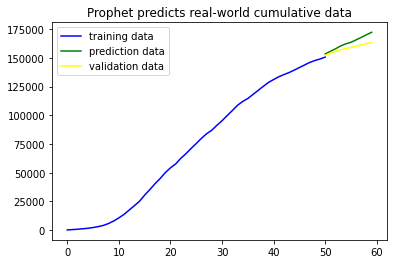

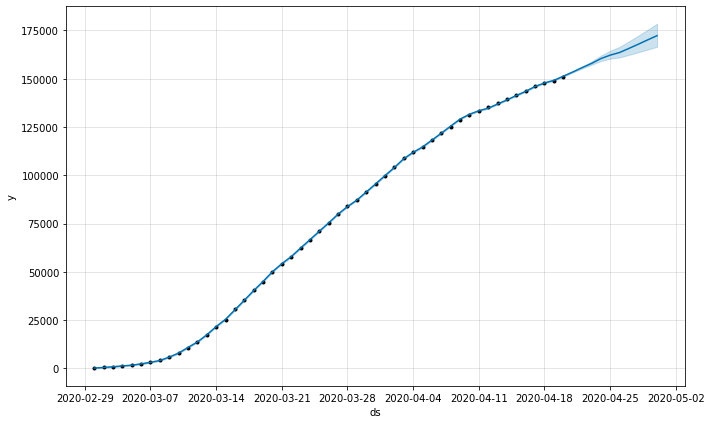

In [28]:
pro = fbprophet.Prophet()
pro.fit(fb_train_cum)
pro_periods = len(valid_data_cum)
future = pro.make_future_dataframe(periods=pro_periods, freq='D')
forecast = pro.predict(future)
three_labels_list(training_data_cum, forecast['yhat'][len(training_data_cum):], valid_data_cum, "Prophet predicts real-world cumulative data")
fig = pro.plot(forecast)

In [29]:
fb_cum_sq_error = sqrt(mean_squared_error(forecast['yhat'][len(training_data_cum):], valid_data_cum))
print('mean square error: ' + str(fb_cum_sq_error))

mean square error: 5193.1376668515695


## initialize LSTM Model  (inspired by https://romanorac.github.io/machine/learning/2019/09/27/time-series-prediction-with-lstm.html)

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
train_arr = scaler.fit_transform(training_data_cum[:, np.newaxis])
val_arr = scaler.transform(valid_data_cum[:, np.newaxis])

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [56]:
seq_len_batch_size = 3

In [57]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

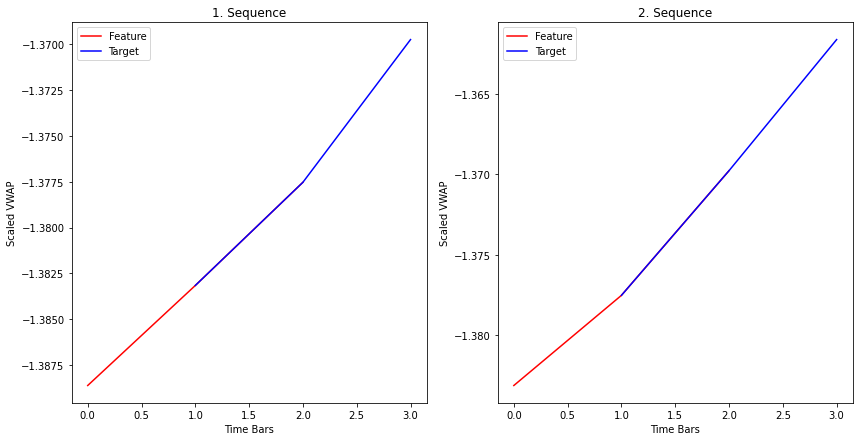

In [35]:
from torch.autograd import Variable

seq_len = seq_len_batch_size

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)

def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [58]:
import torch.nn as nn
import torch.optim as optim
import time
import random

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
    
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch
            
    def train(
        self,
        x_train,
        y_train,
        x_val,
        y_val,
        batch_size,
        n_epochs,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                
            self.scheduler.step()
            train_loss /= batch_size
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch_size 
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch_size
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [59]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})

def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df 

## LSTM

Epoch 1 Train loss: 4.63. Validation loss: 1.77. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 2 Train loss: 4.41. Validation loss: 1.73. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 3 Train loss: 4.28. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 4 Train loss: 4.27. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 5 Train loss: 4.25. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 6 Train loss: 4.25. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 7 Train loss: 4.25. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 8 Train loss: 4.25. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 9 Train loss: 4.25. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 10 Train loss: 4.25. Validation loss: 1.72. Avg future: 0.00. Elapsed time: 0.04s.
Test loss 1.7428


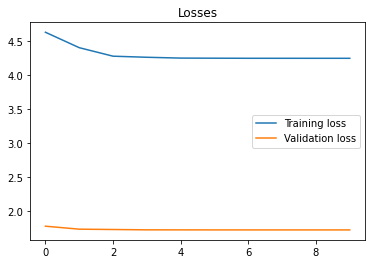

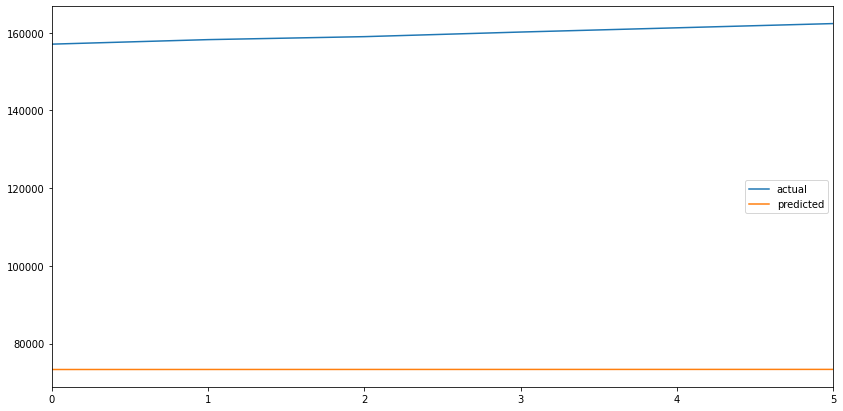

In [61]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=2, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

optimization_1.train(x_train, y_train, x_val, y_val, batch_size=seq_len_batch_size,
        n_epochs=10, do_teacher_forcing=False)

optimization_1.plot_losses()

# prediction
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_val, y_val, future=5, batch_size=seq_len_batch_size)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

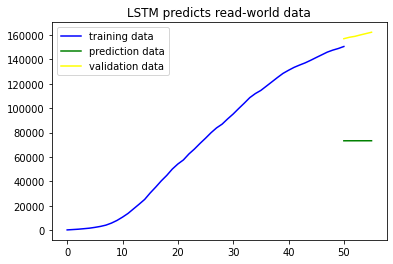

In [62]:
three_labels_list(training_data_cum, df_result_1['predicted'], df_result_1['actual'], "LSTM predicts read-world data" )

In [63]:
lstm_sq_error = sqrt(mean_squared_error(df_result_1['predicted'], df_result_1['actual']))
print('mean square error: ' + str(lstm_sq_error))

mean square error: 86344.24819464401


## Mean square errors 

Text(0.5, 1.0, 'Mean square errors using cumulative infection number ')

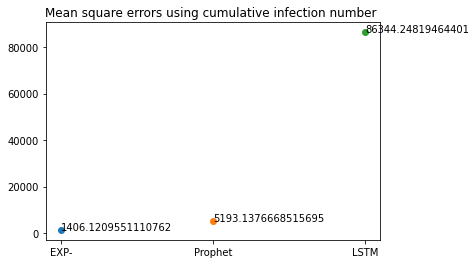

In [66]:
ax = plt.subplot()
labels = ["EXP-", "Prophet", "LSTM"]
errors = [ex_cum_sq_error, fb_cum_sq_error,  lstm_sq_error]

for i in range(len(errors)):
    ax.scatter(labels[i], errors[i])
    ax.annotate(errors[i], (labels[i], errors[i]))
plt.title("Mean square errors using cumulative infection number ")

## Teacher Forcing 

In [85]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, seq_len_batch_size, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2, optimizer_2, scheduler_2)
optimization_2.train(x_train, y_train, x_val, y_val, seq_len_batch_size,
        n_epochs=3, do_teacher_forcing=True)

optimization_2.plot_losses()

actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_val, y_val, future=5, batch_size=seq_len_batch_size)
df_result_2 = to_dataframe(actual_2, predicted_2) 
df_result_2 = inverse_transform(scaler, df_result_2, ['actual', 'predicted'])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

ValueError: non-integer stop for randrange()